In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__)
    print(module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib
3.1.2
numpy
1.17.4
pandas
0.25.3
sklearn
0.22
tensorflow
2.0.0
tensorflow_core.keras
2.2.4-tf


## 1. 准备并处理数据

In [2]:
# 获取数据
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
# 划分数据集
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, 
                                                            housing.target,
                                                            random_state= 1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, 
                                                      y_train_all, 
                                                      random_state = 2)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
# 归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

## 2. 建立模型

model.fit()函数中所做上的事
1. batch 遍历训练集 metric：
    1.1 自动求导；
2. epoch结束 验证集处理 metric；

In [5]:
# metric具有积累性质
metric = keras.metrics.MeanSquaredError()
print(metric([5., 0, 5.],[2., 1., 2]))
print(metric([0.],[1.]))
print(metric.result())

metric.reset_states()  # 清除积累值
metric([1.], [3.])
print(metric.result())

tf.Tensor(6.3333335, shape=(), dtype=float32)
tf.Tensor(3.6666667, shape=(), dtype=float32)
tf.Tensor(3.6666667, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


### 2.1 【重点】自定义训练过程

In [6]:
epochs = 40
batch_size = 32
learning_rate = 1e-3
steps_per_epoch = len(x_train_scaled) // batch_size
optimizer = keras.optimizers.SGD(lr=learning_rate)
metric = keras.metrics.MeanSquaredError()

# 随机选择一批数据
def random_batch(train_data, target, batch_size=batch_size):
    idx = np.random.randint(0, len(train_data), size=batch_size)
    return train_data[idx], target[idx]

customized_model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu",
                       input_shape=x_train.shape[1:]),
    keras.layers.Dense(1),
])

# 遍历数据
customized_history = []
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # 计算loss
        x_batch, y_batch = random_batch(x_train_scaled, y_train, batch_size)
        with tf.GradientTape() as tape:
            """相当于  z=f(x)，这里使用把类当做函数来使用，因为类里实现了__call__方法，
            而在模型里可能是用call方法实现，然后用__call__方法调用call来实现，因为在模
            型子类api重写里面需要重写call函数来实现前向传播"""
            y_pred = customized_model(x_batch)   
            loss = tf.reduce_mean(keras.losses.mean_squared_error(y_batch, y_pred))
 
        metric(y_batch, y_pred)
        # 计算梯度
        grads = tape.gradient(loss, customized_model.variables)
        grads_and_vars = zip(grads, customized_model.variables)   # optimizer.apply_gradients
        optimizer.apply_gradients(grads_and_vars)                 # 函数的输入格式要求
        print("\rEpoch", epoch, " train mse:", metric.result().numpy(), end="")
    customized_history.append(metric.result().numpy())
    metric.reset_states()       # 重置 metric
    # 计算验证集损失
    y_valid_pred= customized_model(x_valid_scaled)
    valid_loss = tf.reduce_mean(keras.losses.mean_squared_error(
                                y_valid_pred, y_valid))
    print("\t", "valid mse: ", valid_loss.numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0  train mse: 2.1446233 0  train mse: 5.069725 train mse: 4.6389093 0  train mse: 4.2632318 0  train mse: 4.118344 0  train mse: 4.0964760  train mse: 3.958511 0  train mse: 3.7676942 0  train mse: 3.666484 0  train mse: 3.6309779 0  train mse: 3.1755207 0  train mse: 3.1442764 0  train mse: 2.83885862.6072872 0  train mse: 2.509469 0  train mse: 2.4320707 0  train mse: 2.3587897 0  train mse: 2.24349570  train mse: 2.2011254 0  train mse: 2.1918316	 valid mse:  1.3936315259330059
Epoch 1  train m

### 2.2 使用keras现成模型

In [7]:
keras_model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", input_shape=x_train.shape[1:]),
    keras.layers.Dense(1)
])

keras_model.compile(loss="mse", optimizer="sgd", metric=["mse"])

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
keras_history = keras_model.fit(x_train_scaled, y_train,
           epochs=40,
           validation_data=(x_valid_scaled, y_valid),
           callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/40
11610/11610 [==============================] - 1s 85us/sample - loss: 0.9285 - val_loss: 0.6385
Epoch 2/40
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6834 - val_loss: 0.5146
Epoch 3/40
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5691 - val_loss: 0.4906
Epoch 4/40
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4857 - val_loss: 0.4854
Epoch 5/40
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4885 - val_loss: 0.4817
Epoch 6/40
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4811 - val_loss: 0.4691
Epoch 7/40
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4766 - val_loss: 0.5614
Epoch 8/40
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5650 - val_loss: 0.4710
Epoch 9/40
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4757 - val_l

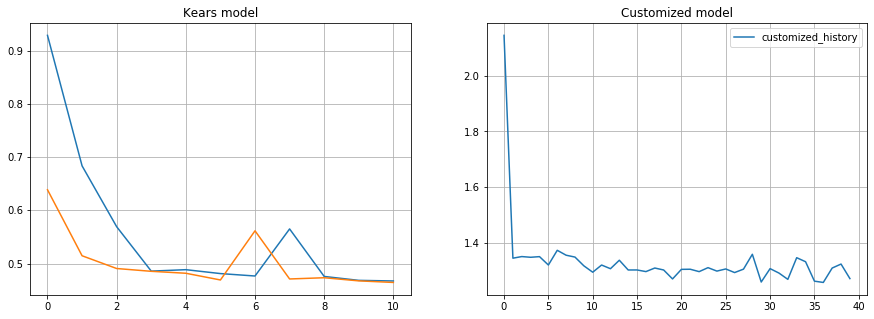

In [8]:
def plot_learning_curves(customized_history, keras_history):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(pd.DataFrame(keras_history.history))
    plt.title("Kears model")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(range(len(customized_history)), customized_history, label="customized_history")
    plt.title("Customized model")
    plt.legend()
    plt.grid(True)
    plt.plot()

plot_learning_curves(customized_history, keras_history)

从上面两个图可以看出，keras经过优化的模型计算的损失更低更加平稳，这跟模型中的各种优化有关，而自己自定义的模型只是一个比较粗糙的，所以精确度更低并且并不是很稳定